In [1]:
import geopandas as gpd
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Read all GeoPackages
folder_path = r'C:\Users\b8008458\Documents\scratch_space\linux_outputs\outputs\scored_neighbourhoods'
gdf_list = []

for file in os.listdir(folder_path):
    if file.endswith('.gpkg'):
        gdf = gpd.read_file(os.path.join(folder_path, file))
        gdf_list.append(gdf)

# Step 2: Combine all GeoDataFrames into one
combined_gdf = pd.concat(gdf_list, ignore_index=True)

# Step 3: Ensure the three columns are numeric
columns_of_interest = ["rat_run_score", "mean_distance_diff_score", "filter_road_density_score"]
combined_gdf[columns_of_interest] = combined_gdf[columns_of_interest].apply(pd.to_numeric, errors='coerce')

# Handle any potential NaN values
combined_gdf = combined_gdf.dropna(subset=columns_of_interest)

# Step 4: Perform PCA
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_gdf[columns_of_interest])

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Add PCA results back to the GeoDataFrame
for i in range(pca_result.shape[1]):
    combined_gdf[f'PCA_{i+1}'] = pca_result[:, i]

# Display the explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

combined_gdf.head(), explained_variance


(   rat_run_score  mean_distance_diff_score  filter_road_density_score  \
 0          100.0                  5.405502                        0.0   
 1          100.0                  0.000000                        0.0   
 2          100.0                 11.946186                        0.0   
 3          100.0                  1.360174                        0.0   
 4          100.0                  0.000000                        0.0   
 
         overall_score cluster_label  \
 0  50.675687726126206             0   
 1                50.0             0   
 2  51.493273264865635             0   
 3   50.17002178293668             0   
 4                50.0             0   
 
                                             geometry     PCA_1     PCA_2  \
 0  POLYGON ((-2.66309 51.31205, -2.66309 51.31205... -1.237904  0.434917   
 1  POLYGON ((-2.66506 51.31390, -2.66506 51.31390... -1.354413  0.404180   
 2  POLYGON ((-2.68224 51.31648, -2.68224 51.31648... -1.096928  0.472109   
 3  

Explained Variance Ratio: [0.47195054 0.29113613 0.23691332]


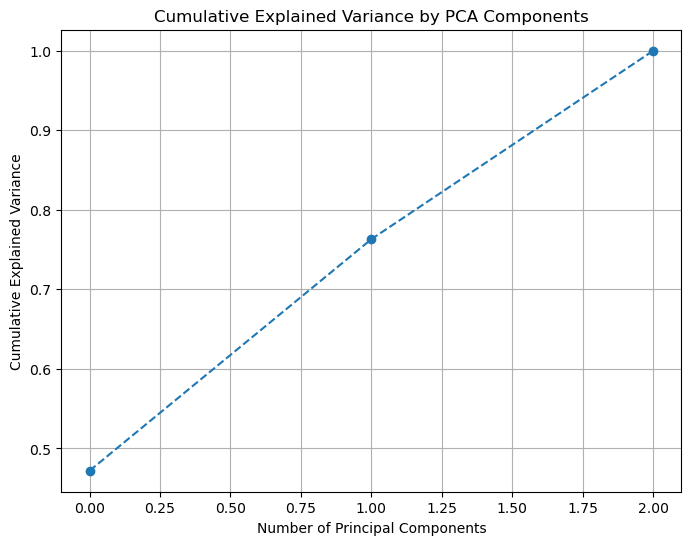

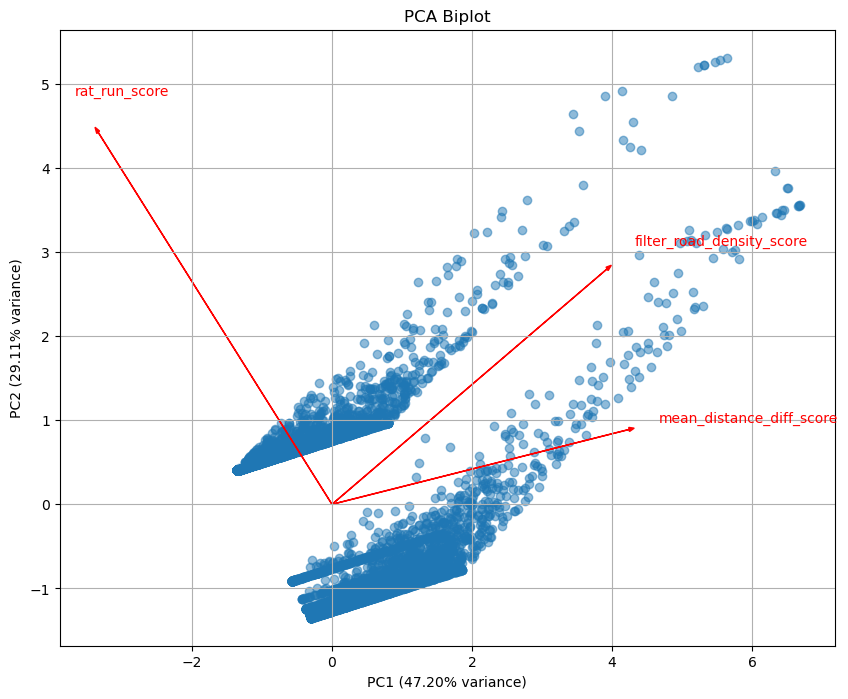

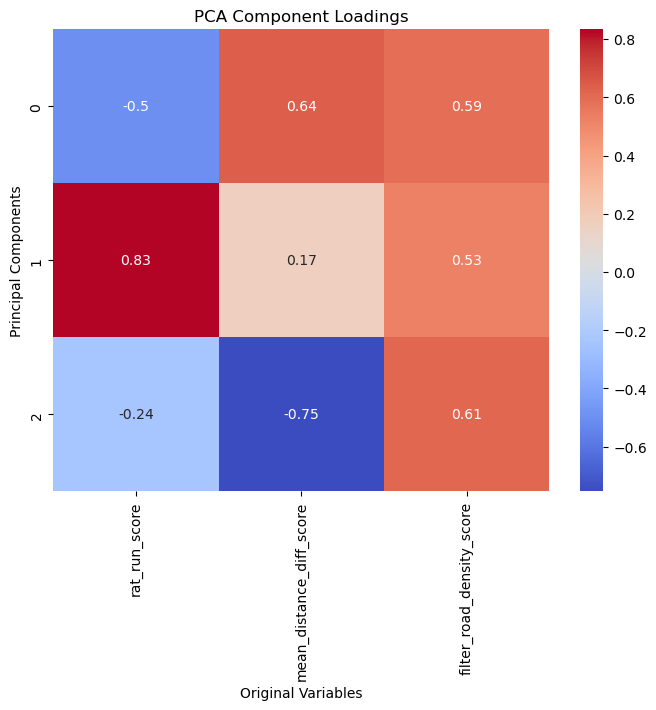

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# 2. Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# 3. Biplot
def biplot(pca, gdf, pc1=0, pc2=1, labels=None):
    xvector = pca.components_[pc1]
    yvector = pca.components_[pc2]
    xs = gdf[f'PCA_{pc1+1}']
    ys = gdf[f'PCA_{pc2+1}']
    
    plt.figure(figsize=(10, 8))
    plt.scatter(xs, ys, alpha=0.5)
    
    if labels is None:
        labels = gdf.columns
    
    for i in range(len(xvector)):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.002, head_width=0.05)
        plt.text(xvector[i]*max(xs)*1.1, yvector[i]*max(ys)*1.1,
                 labels[i], color='r')
    
    plt.xlabel(f'PC{pc1+1} ({explained_variance[pc1]*100:.2f}% variance)')
    plt.ylabel(f'PC{pc2+1} ({explained_variance[pc2]*100:.2f}% variance)')
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.show()

# Call biplot function
biplot(pca, combined_gdf, labels=columns_of_interest)

# 4. Heatmap of Component Loadings
loading_matrix = pd.DataFrame(pca.components_, columns=columns_of_interest)
plt.figure(figsize=(8, 6))
sns.heatmap(loading_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('PCA Component Loadings')
plt.xlabel('Original Variables')
plt.ylabel('Principal Components')
plt.show()


In [3]:
# Retrieve the loadings
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2', 'PC3'], 
                        index=columns_of_interest)

print(loadings)


                                PC1       PC2       PC3
rat_run_score             -0.500121  0.833084 -0.236326
mean_distance_diff_score   0.635413  0.167632 -0.753757
filter_road_density_score  0.588327  0.527134  0.613189


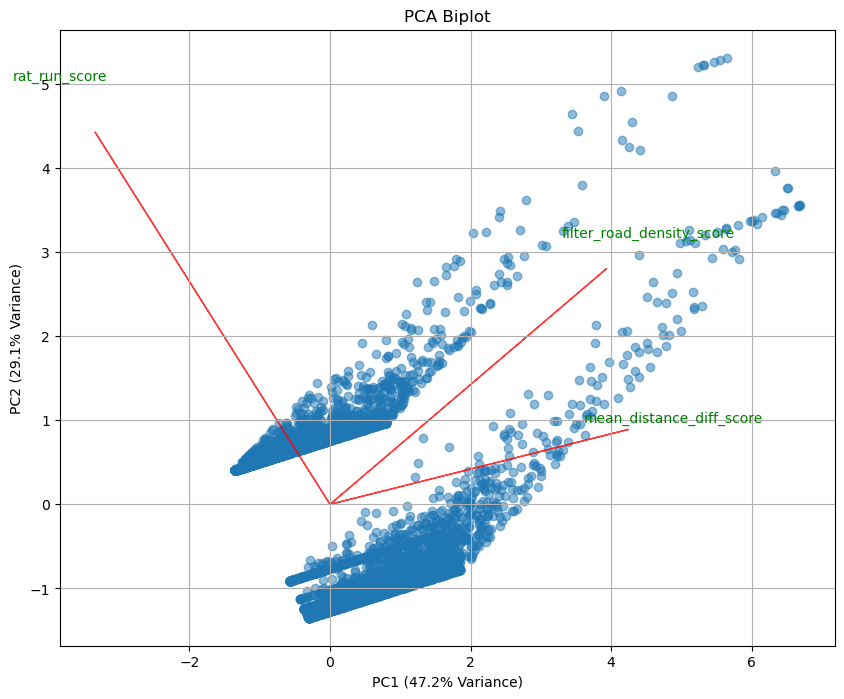

In [6]:

import matplotlib.pyplot as plt

def biplot(gdf, loadings, pc1=0, pc2=1):
    plt.figure(figsize=(10, 8))
    plt.scatter(gdf[f'PCA_{pc1+1}'], gdf[f'PCA_{pc2+1}'], alpha=0.5)
    
    for var in loadings.index:
        plt.arrow(0, 0, 
                  loadings.loc[var, f'PC{pc1+1}'] * max(gdf[f'PCA_{pc1+1}']), 
                  loadings.loc[var, f'PC{pc2+1}'] * max(gdf[f'PCA_{pc2+1}']), 
                  color='r', alpha=0.75)
        plt.text(loadings.loc[var, f'PC{pc1+1}'] * max(gdf[f'PCA_{pc1+1}']) * 1.15,
                 loadings.loc[var, f'PC{pc2+1}'] * max(gdf[f'PCA_{pc2+1}']) * 1.15,
                 var, color='g', ha='center', va='center')
    
    plt.xlabel(f'PC{pc1+1} ({explained_variance[pc1]*100:.1f}% Variance)')
    plt.ylabel(f'PC{pc2+1} ({explained_variance[pc2]*100:.1f}% Variance)')
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.show()

# Call the biplot function
biplot(combined_gdf, loadings)
